# Evaluation ConvLSTM SSH-SST: 

This notebook presents the evaluation of the SSH reconstructions based on the ConvLSTM SSH-SST method presented in ([Martin et al., 2023]( https://doi.org/10.1029/2022MS003589) and performed for the **"2021a_SSH_mapping_OSE" ocean data challenge**. 

Note that this method additionally uses L4 SST from the NASA MUR SST product to improve the mapping of mesoscale eddies.

\* Results presented here differ slightly from those in [Martin et al., 2023]( https://doi.org/10.1029/2022MS003589) since here we patch a few overlapping ConvLSTM predictions together using the kernel-weighted averaging procedure described in [Martin et al., 2024]( https://doi.org/10.1029/2024GL110059) - but the NN weights are those from .

In [1]:
import os
import sys
sys.path.append('..')
import logging
import pandas as pd

In [2]:
from src.mod_inout import *
from src.mod_interp import *
from src.mod_stats import *
from src.mod_spectral import *
from src.mod_plot import *

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### Study Area & Ouput Parameters

In [4]:
# study area
lon_min = 295.
lon_max = 305.
lat_min = 33.
lat_max = 43.
is_circle = False
time_min = '2017-01-01'
time_max = '2017-12-31'

# Outputs
bin_lat_step = 1.
bin_lon_step = 1.
bin_time_step = '1D'
output_directory = '../results'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
output_filename = f'{output_directory}/stat_OSE_convlstm_ssh-sst_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'
output_filename_timeseries = f'{output_directory}/stat_timeseries_OSE_convlstm_ssh-sst_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'

# Spectral parameter
# C2 parameter
delta_t = 0.9434  # s
velocity = 6.77   # km/s
delta_x = velocity * delta_t
lenght_scale = 1000 # km
output_filename_spectrum = f'{output_directory}/psd_OSE_convlstm_ssh-sst_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'

### Open your AVISO+ session: fill the ```<AVISO_LOGIN>``` and ```<AVISO_PWD>``` items below

In [ ]:
my_aviso_session = rq.Session()
my_aviso_session.auth = ("<AVISO_LOGIN>", "<AVISO_PWD>")
url_alongtrack = 'https://tds.aviso.altimetry.fr/thredds/dodsC/2021a-SSH-mapping-OSE-along-track-data'
url_map = 'https://tds.aviso.altimetry.fr/thredds/dodsC/2021a-SSH-mapping-OSE-grid-data'

### Read L3 datasets

In [5]:
# independent along-track
alontrack_independent_dataset = f'../data/dc_obs/dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc'
# Read along-track
ds_alongtrack = read_l3_dataset(alontrack_independent_dataset, 
                                           lon_min=lon_min, 
                                           lon_max=lon_max, 
                                           lat_min=lat_min, 
                                           lat_max=lat_max, 
                                           time_min=time_min, 
                                           time_max=time_max)
ds_alongtrack

<xarray.Dataset>
Dimensions:         (time: 50196)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01T08:08:42.012641024 ... 2...
    longitude       (time) float64 297.4 297.4 297.4 297.4 ... 297.9 297.9 297.9
    latitude        (time) float64 33.03 33.09 33.15 33.2 ... 42.83 42.89 42.95
Data variables:
    cycle           (time) float64 88.0 88.0 88.0 88.0 ... 101.0 101.0 101.0
    track           (time) float64 701.0 701.0 701.0 701.0 ... 353.0 353.0 353.0
    dac             (time) float32 -0.1647 -0.1648 -0.165 ... 0.03 0.0314 0.0327
    lwe             (time) float32 0.003 0.003 0.003 ... -0.029 -0.029 -0.029
    mdt             (time) float32 0.593 0.592 0.591 ... -0.165 -0.164 -0.163
    ocean_tide      (time) float64 -0.3407 -0.3413 -0.342 ... -0.1686 -0.1693
    sla_filtered    (time) float32 -0.136 -0.16 -0.18 -0.194 ... 0.105 0.102 0.1
    sla_unfiltered  (time) float32 -0.151 -0.119 -0.158 ... 0.081 0.097 0.114
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

### Read L4 dataset and interpolate onto along-track positions

In [6]:
# series of maps to evaluate
gridded_dataset = f'../data/dc_maps/OSE_ssh_mapping_convlstm_ssh-sst.nc'
# Interpolate maps onto alongtrack dataset
time_alongtrack, lat_alongtrack, lon_alongtrack, ssh_alongtrack, ssh_map_interp = interp_on_alongtrack(gridded_dataset, 
                                                                                                       ds_alongtrack,
                                                                                                       lon_min=lon_min, 
                                                                                                       lon_max=lon_max, 
                                                                                                       lat_min=lat_min, 
                                                                                                       lat_max=lat_max, 
                                                                                                       time_min=time_min, 
                                                                                                       time_max=time_max,
                                                                                                       is_circle=is_circle)

### Compute statistical score

In [7]:
leaderboard_nrmse, leaderboard_nrmse_std = compute_stats(time_alongtrack, 
                                                         lat_alongtrack, 
                                                         lon_alongtrack, 
                                                         ssh_alongtrack, 
                                                         ssh_map_interp, 
                                                         bin_lon_step,
                                                         bin_lat_step, 
                                                         bin_time_step,
                                                         output_filename,
                                                         output_filename_timeseries)

INFO:root:  Results saved in: ../results/stat_OSE_convlstm_ssh-sst_2017-01-01_2017-12-31_295.0_305.0_33.0_43.0.nc
INFO:root: 
INFO:root:  Results saved in: ../results/stat_timeseries_OSE_convlstm_ssh-sst_2017-01-01_2017-12-31_295.0_305.0_33.0_43.0.nc
INFO:root: 
INFO:root:  MEAN RMSE Score = 0.9016324970492635
INFO:root: 
INFO:root:  STD RMSE Score = 0.06213689890266927


In [8]:
plot_spatial_statistics(output_filename)

:Image   [lon,lat]   (rmse)

In [9]:
plot_temporal_statistics(output_filename_timeseries)

:Layout
   .Curve.I  :Curve   [time]   (rms)
   .Curve.II :Curve   [time]   (count)

### Compute spectral scores

In [10]:
compute_spectral_scores(time_alongtrack, 
                        lat_alongtrack, 
                        lon_alongtrack, 
                        ssh_alongtrack, 
                        ssh_map_interp, 
                        lenght_scale,
                        delta_x,
                        delta_t,
                        output_filename_spectrum)

INFO:root:  Results saved in: ../results/psd_OSE_convlstm_ssh-sst_2017-01-01_2017-12-31_295.0_305.0_33.0_43.0.nc


INFO:root: 
INFO:root:  Minimum spatial scale resolved = 100km


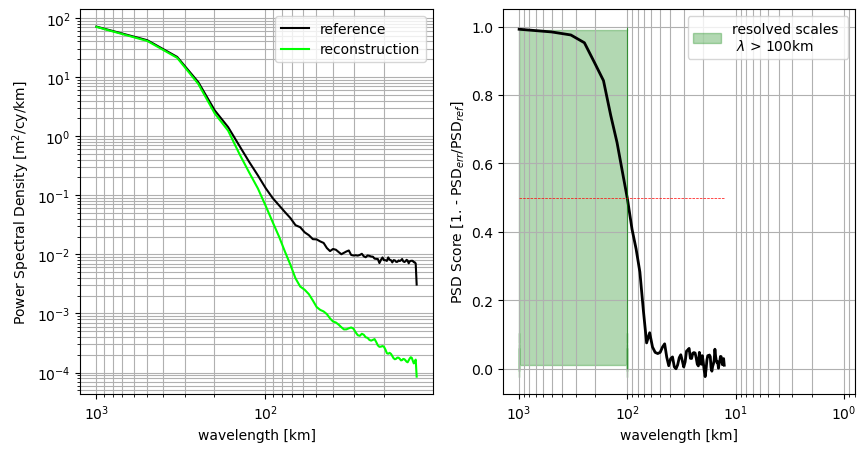

In [11]:
leaderboard_psds_score = plot_psd_score(output_filename_spectrum)

### Show leaderboard metrics

In [12]:
# Print leaderboard
data = [['ConvLSTM SSH-SST', 
         leaderboard_nrmse, 
         leaderboard_nrmse_std, 
         int(leaderboard_psds_score),
        'Covariances ConvLSTM SSH-SST',
        'example_eval_convlstm_ssh-sst.ipynb']]
Leaderboard = pd.DataFrame(data, 
                           columns=['Method', 
                                    "µ(RMSE) ", 
                                    "σ(RMSE)", 
                                    'λx (km)',  
                                    'Notes',
                                    'Reference'])
print("Summary of the leaderboard metrics:")
Leaderboard
print(Leaderboard.to_markdown())

Summary of the leaderboard metrics:
|    | Method           |   µ(RMSE)  |   σ(RMSE) |   λx (km) | Notes                        | Reference                           |
|---:|:-----------------|-----------:|----------:|----------:|:-----------------------------|:------------------------------------|
|  0 | ConvLSTM SSH-SST |   0.901632 | 0.0621369 |       100 | Covariances ConvLSTM SSH-SST | example_eval_convlstm_ssh-sst.ipynb |
